# 주제 : 추천 시스템 - 영화 데이터셋과 Rating Matrix를 활용하여 추천 모델 학습하기
----------

## 실습 가이드
    1. 데이터를 다운로드하여 Colab에 불러옵니다.
    2. 필요한 라이브러리는 모두 코드로 작성되어 있습니다.
    3. 코드는 위에서부터 아래로 순서대로 실행합니다.
    4. 전체 문제 구성은 좌측 첫 번째 아이콘을 통해 확인할 수 있습니다.
    
    
## 데이터 소개
    - 이번 주제는 MovieLens Dataset을 사용합니다.
    - 파일은 두 개 이며, 각각의 컬럼은 아래와 같습니다.
    
    1. ratings.dat
    user_id : 영화를 시청한 사용자 아이디
    movie_id : 영화의 아이디
    rating : 사용자가 영화를 평가한 점수
    time : 사용자가 영화를 시청한 시간
    
    2. movies.dat
    movie_id : 영화의 아이디
    title : 영화 제목
    genre : 영화 장르

    
- 데이터 출처: https://grouplens.org/datasets/movielens/


## 최종 목표
    - CF(Collaborative Filtering) 기반 추천 모델의 이해
    - Matrix Factorization 기반 추천 모델의 이해
    - KNN, SVD 알고리즘에 대한 이해
    - 훈련된 모델의 결과를 해석하는 방법 습득
    - 모델의 추천 결과를 평가하는 방법 습득

- 출제자 : 윤기태 강사
---

## Step 1. 데이터 전처리 과정

### 문제 1. 데이터 불러오기

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

rating_url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/ml-1m/ratings.dat'
rating_df = pd.io.parsers.read_csv(rating_url, names=['user_id', 'movie_id', 'rating', 'time'], delimiter='::', engine ='python')


display(rating_df.head())
print(rating_df.shape)

# time : unix time

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


(1000209, 4)


In [2]:
movie_url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/ml-1m/movies.dat'
movie_df = pd.io.parsers.read_csv(movie_url, names=['movie_id', 'title', 'genre'], delimiter='::', engine ='python', encoding='ISO-8859-1')

display(movie_df.head())
print(movie_df.shape)


,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


(3883, 3)


### 문제 2. EDA - 사용자 수와 영화의 수 탐색

In [3]:
print('사용자 수 : ',len(rating_df['user_id'].unique()))
print('영화 수 : ', len(movie_df['movie_id'].unique()))

사용자 수 :  6040
영화 수 :  3883


### 문제 3. EDA - 영화 평가 점수의 분포 탐색

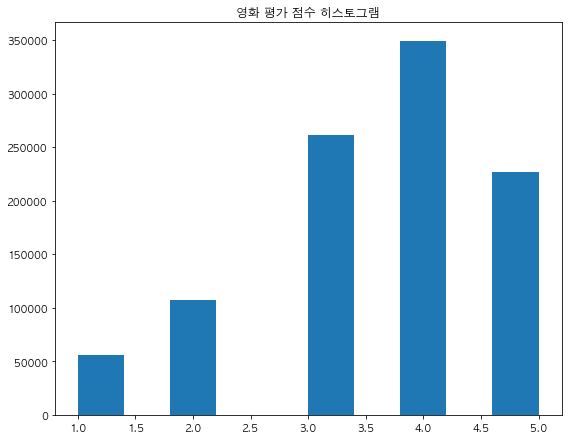

In [4]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'AppleGothic'

plt.figure(figsize=(8, 6))
plt.hist(rating_df['rating'])
plt.tight_layout()
plt.title('영화 평가 점수 히스토그램')
plt.show()

## Step 2. CF-based 모델링 (KNN)

### Rating Matrix와 Colaborative Filtering (CF)
----------

#### Rating Matrix

![rating matrix](https://www.researchgate.net/profile/Giuseppe_Manco3/publication/220907096/figure/fig1/AS:305570830667776@1449865171054/An-example-of-rating-matrix.png)

    1. User를 Row, Item을 Column으로 하며 Value를 Rating으로 하는 행렬
    2. Rating의 종류
      - Explicit Feedback : 영화 점수, 리뷰 점수, 좋아요 표시...
      - Implicit Feedback : 조회, 시청, 구매, 찜 표시...
    3. Rating Matrix를 추천 모델로 활용하는 방법
      - Colaborative Filtering (CF)
      - Matrix Factorization (MF)

-----

#### Colaborative Filtering (CF)

![CF](https://t1.daumcdn.net/cfile/tistory/9970CE495AF71C0C06)

> 고객들의 선호도와 관심 표현을 바탕으로 선호도, 관심에서 비슷한 패턴을 가진 고객들을 식별해 내는 기법이다. 비슷한 취향을 가진 고객들에게 서로 아직 구매하지 않은 상품들은 교차 추천하거나 분류된 고객의 취향이나 생활 형태에 따라 관련 상품을 추천하는 형태의 서비스를 제공하기 위해 사용된다.
    
    1. User-based
    2. Item-based

-----

### 문제 4. 모델링 - Train/Test 데이터 분리

In [5]:
# !pip install surprise

In [6]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split

reader = Reader(rating_scale=(1, 5)) # 점수 범위를 명시
data = Dataset.load_from_df(rating_df[['user_id', 'movie_id', 'rating']], reader=reader) # uid, iid, rating 순으로 입력

# Reader, Dataset 오브젝트로 학습용 데이터셋 생성 및 분리

train_df, test_df = train_test_split(data, test_size=0.2)

In [7]:
print('사용자 수 : ',train_df.n_users)
print('아이템 수 : ',train_df.n_items)
print('평점 수 : ',train_df.n_ratings)

사용자 수 :  6040
아이템 수 :  3687
평점 수 :  800167


### 문제 5. 모델링 - KNN 모델 학습

-----

#### KNN (K-Nearest Neighbor) 알고리즘

![knn](http://i.imgur.com/gLBo1gX.png)

    [KNN의 대략적인 이해]
    1. 새로운(혹은 특정한) 데이터 포인트 X가 있을 때, X와 가장 유사한 k개를 이용하여 데이터 포인트 X의 위치를 찾는 알고리즘
    2. euclidean distance, cosine similarity 등을 기준으로 유사한 k개를 계산
    3. 분류(classification) 문제의 경우는 k개의 포인트에서 가장 많이 등장한 class로 할당
    4. 예측(regression) 문제의 경우는 k개 포인트의 평균 값, 혹은 가중치 값 등으로 X의 값을 예측

#### Surprise의 KNN

> A basic collaborative filtering algorithm. The prediction 𝑟̂ 𝑢𝑖 is set as

![suprise knn](https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/images/knn.png)

###### (https://surprise.readthedocs.io/en/stable/knn_inspired.html)
    
    [라이브러리의 대략적인 학습 과정]
    1. User-based CF
    2. 유저 A와 가장 영화를 유사하게 평가한 유저 k명을 선정
    3. k명의 유저가 영화 a를 평가한 점수를 활용하여 위의 식대로 점수를 계산함
    4. 이와 같은 방식으로 Rating Matrix를 완성
-----
    [Similarity]
    1. 가장 일반적인 Similarity 계산 방식은 cosine similarity
    2. 다른 방식은 euclidean distance, jaccard index, pearson correlation 등이 있음

![cosine](https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/images/cosine.png)
-----

In [8]:
# KNN 이해를 돕기 위한 참고 코드
ab = (0.9 * 4) + (0.8 * 3) + (0.7 * 5) + (0.6 * 1) # 유사도 * rating
bb = 0.9 + 0.8 + 0.7 + 0.6 # 유사도

ab/bb

3.3666666666666663

In [9]:
# KNNBasic 모델 학습
from surprise import KNNBasic

model = KNNBasic(k=40, min_k=1, sim_options={'user_based': True, 'name' : 'cosine'}, verbose=True)
model.fit(train_df)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [10]:
pred = model.test(test_df)

### 문제 6. 모델링 - RMSE 평가

In [11]:
# accuracy로 rmse 평가
from surprise import accuracy

accuracy.rmse(pred)

RMSE: 0.9747


0.9747297340265912

### 문제 7. 모델 평가 - 테스트 데이터셋에서 일부 결과 확인

In [12]:
# test 함수의 결과를 활용하여 모델을 정성적으로 평가
predictions = model.test(test_df[:20])
predictions

[Prediction(uid=2070, iid=288, r_ui=1.0, est=3.550065392627042, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=5749, iid=1699, r_ui=5.0, est=3.7758644841222977, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=3618, iid=2054, r_ui=2.0, est=3.6014752499873186, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=4322, iid=2712, r_ui=1.0, est=3.0487398093247933, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=5268, iid=2457, r_ui=4.0, est=3.600259302761955, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=3292, iid=3083, r_ui=5.0, est=4.300639299725354, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=2462, iid=246, r_ui=4.0, est=4.224841366713836, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=732, iid=527, r_ui=4.0, est=4.75, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=2816, iid=861, r_ui=2.0, est=3.6992145439560047, details={'act

## Step 3. MF-based 모델링 (SVD)

### 문제 8. 모델링 - Train/Test 데이터 분리

In [13]:
# Reader, Dataset 오브젝트로 학습용 데이터셋 생성 및 분리
from surprise import Reader, Dataset

reader = Reader(rating_scale=(1, 5))

df = Dataset.load_from_df(rating_df[['user_id', 'movie_id', 'rating']], reader)
train_df, test_df = train_test_split(df, test_size=0.2)

### 문제 9. 모델링 - SVD 모델 학습

-----

#### Matrix Factorization의 개념

![MF](https://t1.daumcdn.net/cfile/tistory/99EAC1455AF71F3E31)

![MF2](https://media.springernature.com/lw785/springer-static/image/chp%3A10.1007%2F978-3-319-65930-5_47/MediaObjects/455696_1_En_47_Fig3_HTML.gif)

    [MF의 대략적인 이해]
    1. 원래의 행렬을 다른 2개 행렬로 분해하고, 이를 다시 원래 모양으로 만드는 과정을 Factorization 이라고 함.
    2. 그 과정에서 Latent Factor 라는 것을 활용하여, 행과 열의 성질을 만들어낼 수 있음.
    3. latent factor를 충분히 많이 만들게 되면, 유저와 아이템의 성질을 벡터로 표현 가능.
    4. 일반적으로 지도 학습을 통해 P와 Q를 찾게 되고, 이를 Model-based CF 라고 하기도 함.

#### Surprise의 SVD

> The famous SVD algorithm, as popularized by Simon Funk during the Netflix Prize. When baselines are not used, this is equivalent to Probabilistic Matrix Factorization

> The prediction 𝑟̂ 𝑢𝑖 is set as:

![r_ui](https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/images/r_ui_1.png)

###### (https://surprise.readthedocs.io/en/stable/matrix_factorization.html)
    
    [라이브러리의 대략적인 학습 과정]
    1. Model-based MF
    2. 이미 점수가 존재하는 r_ui를 기준으로 P, Q를 학습.
    3. 특정 epoch, 혹은 수렴 조건에 달할 때 까지 학습 (Gradient Descent)

![r_ui](https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/images/r_ui_2.png)

![r_ui](https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/images/r_ui_3.png)

-----

In [14]:
from surprise import SVD

# SVD 모델 학습

model = SVD()
model.fit(train_df)

# 예측
pred = model.test(test_df)

### 문제 10. 모델링 - RMSE 평가

In [15]:
# 앞에서와 동일하게 accuracy 함수로 rmse 평가

accuracy.rmse(pred)

RMSE: 0.8722


0.8721616154390461

### 문제 11. 모델링 & 시각화 - RMSE를 개선하는 파라미터 튜닝 자동화

In [16]:
import time

# 실험해볼 파라미터 리스트와 결과를 저장할 변수 정의
param_list = [10, 50, 100, 150, 200]
rmse_list_by_factors = []
ttime_list_by_factors = []

# 반복문을 활용하여 파라미터 튜닝 관찰 및 자동화

for idx,param in enumerate(param_list):
    startpoint = time.time()
    model = SVD(n_factors=param)
    model.fit(train_df)
    endpoint = time.time()
    pred = model.test(test_df)
    evaluation = accuracy.rmse(pred)
    print(f'{idx + 1}번쨰 Time : {endpoint - startpoint}')
    print(f'{idx + 1}번쨰 RMSE : {evaluation}')
    rmse_list_by_factors.append(evaluation)
    ttime_list_by_factors.append(endpoint-startpoint)
print('Finish!')

RMSE: 0.8734
1번쨰 Time : 11.402381658554077
1번쨰 RMSE : 0.8734168396524684
RMSE: 0.8705
2번쨰 Time : 26.07586693763733
2번쨰 RMSE : 0.8704622861275645
RMSE: 0.8723
3번쨰 Time : 44.002307176589966
3번쨰 RMSE : 0.8722588305936536
RMSE: 0.8749
4번쨰 Time : 61.126168966293335
4번쨰 RMSE : 0.8749451460184903
RMSE: 0.8772
5번쨰 Time : 78.83549690246582
5번쨰 RMSE : 0.8771648744075028
Finish!


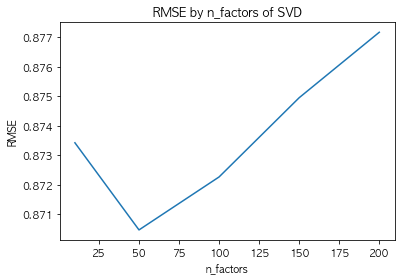

In [17]:
# plt의 plot 함수로 결과 시각화

plt.plot(param_list, rmse_list_by_factors)
plt.title('RMSE by n_factors of SVD')
plt.ylabel('RMSE')
plt.xlabel('n_factors')
plt.show()

## 과대적합 조심하고 적절한 n_factors를 정하는 것이 중요!

### 문제 12. 모델 평가 - 최종 RMSE 평가

In [18]:
# accuracy로 rmse 평가
model = SVD(n_factors=50)
model.fit(train_df)
pred = model.test(test_df)

accuracy.rmse(pred)

RMSE: 0.8692


0.8691590502037089

### 문제 13. 모델 평가 - 테스트 데이터셋에서 일부 결과 확인

In [19]:
# test 함수의 결과를 활용하여 모델을 정성적으로 평가
predictions = model.test(test_df[:20])
predictions

[Prediction(uid=4344, iid=1252, r_ui=5.0, est=4.491027405403186, details={'was_impossible': False}),
 Prediction(uid=5623, iid=1373, r_ui=4.0, est=3.3313720743845634, details={'was_impossible': False}),
 Prediction(uid=3329, iid=1942, r_ui=3.0, est=3.7131512947571084, details={'was_impossible': False}),
 Prediction(uid=1670, iid=1584, r_ui=5.0, est=4.643058252219987, details={'was_impossible': False}),
 Prediction(uid=869, iid=3512, r_ui=4.0, est=4.1275527544839035, details={'was_impossible': False}),
 Prediction(uid=5108, iid=2019, r_ui=4.0, est=4.432632512027354, details={'was_impossible': False}),
 Prediction(uid=2290, iid=1957, r_ui=2.0, est=3.231572783619733, details={'was_impossible': False}),
 Prediction(uid=3716, iid=1242, r_ui=5.0, est=4.394093521987367, details={'was_impossible': False}),
 Prediction(uid=4053, iid=3654, r_ui=4.0, est=3.867401933193017, details={'was_impossible': False}),
 Prediction(uid=1812, iid=1258, r_ui=5.0, est=3.939461584330178, details={'was_impossible

## Step 4. 추천 결과 평가

-----

#### CF, MF 기반 추천시스템의 가정(한계)

    [가정 : 사용자의 과거 Preference는 미래에서도 동일하다]
    1. Time Series로 추정된 선호도가 아닌, Estimate 되거나 Factorized 된 점수
    2. A시점에 평가한 선호도와, B시점에 평가한 선호도가 동일 선에서 학습됨
    3. Test 데이터에 대한 평가 역시, 시간이 고려되지 않은 "랜덤한 빈공간 찾기" 식으로 평가됨

- 이번 챕터의 목표
  - `학습은 그렇다 치고, 평가라도 시간을 고려해서 해보자`

### 문제 14. 추천 결과 평가 - 사용자별 전체 시청리스트 추출

In [20]:
# groupby와 apply 함수를 이용하여 사용자별 시청리스트 추출

user_watch_dict_list = rating_df.groupby('user_id')[['user_id', 'movie_id']].apply(lambda x: x['movie_id'].tolist())
user_watch_dict_list[:5]

user_id
1    [1193, 661, 914, 3408, 2355, 1197, 1287, 2804,...
2    [1357, 3068, 1537, 647, 2194, 648, 2268, 2628,...
3    [3421, 1641, 648, 1394, 3534, 104, 2735, 1210,...
4    [3468, 1210, 2951, 1214, 1036, 260, 2028, 480,...
5    [2987, 2333, 1175, 39, 288, 2337, 1535, 1392, ...
dtype: object

### 문제 15. 추천 결과 평가 - 특정 시간 기준 사용자별 Train/Test 시청리스트 추출
추천 결과 평가 - 특정 시간 기준 유저별 시청 목록 추출 (Train/Test과 동일 기준)

<AxesSubplot:>

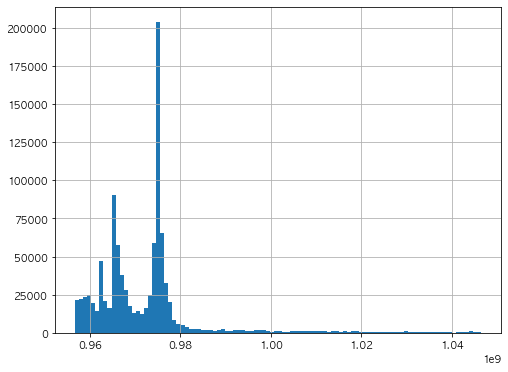

In [21]:
# 시간별 시청 분포 탐색
plt.figure(figsize=(8, 6))
rating_df['time'].hist(bins=100)

In [22]:
# 8:2 로 분할할 수 있는 시간 지정
q82 = rating_df['time'].quantile(q=0.8, interpolation='nearest')
q82

975768738

In [23]:
# 지정된 시간으로 데이터셋 분리

train_df = rating_df.loc[rating_df['time'] < q82, ['user_id', 'movie_id', 'rating']]
test_df = rating_df.loc[rating_df['time'] >= q82, ['user_id', 'movie_id', 'rating']]

print(f'Train DataFrame Shape : {train_df.shape}')
print(f'Users count of Train df : {train_df["user_id"].nunique()}')
print(f'Movies count of Train df : {train_df["movie_id"].nunique()}')
print('\n-----------------------------------\n')
print(f'Test DataFrame Shape : {test_df.shape}')
print(f'Users count of Test df : {test_df["user_id"].nunique()}')
print(f'Movies count of Test df : {test_df["movie_id"].nunique()}')

Train DataFrame Shape : (800164, 3)
Users count of Train df : 5400
Movies count of Train df : 3662

-----------------------------------

Test DataFrame Shape : (200045, 3)
Users count of Test df : 1783
Movies count of Test df : 3511


In [24]:
test_df.groupby('user_id').apply(lambda x: x['movie_id'].tolist())

user_id
1       [1193, 661, 914, 3408, 2355, 1197, 1287, 2804,...
2       [1357, 3068, 1537, 647, 2194, 648, 2268, 2628,...
3       [3421, 1641, 648, 1394, 3534, 104, 2735, 1210,...
4       [3468, 1210, 2951, 1214, 1036, 260, 2028, 480,...
5       [2987, 2333, 1175, 39, 288, 2337, 1535, 1392, ...
                              ...                        
6001    [589, 1438, 965, 3481, 2875, 3147, 1552, 2917,...
6002    [3789, 3011, 1419, 3037, 902, 2098, 909, 3093,...
6016    [3795, 2062, 2065, 900, 3044, 1441, 914, 920, ...
6028                                               [3000]
6040    [2068, 953, 3421, 232, 3182, 2571, 2575, 1921,...
Length: 1783, dtype: object

### 문제 16. 추천 결과 평가 - 모델 기반 사용자별 선호 시청리스트 추출

In [25]:
train_df

,user_id,movie_id,rating
94507,635,1251,4
94513,635,3948,4
94518,635,1270,4
94519,635,1279,5
94522,635,1286,4
...,...,...,...
1000204,6040,1091,1
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4


In [26]:
# 위에서 추출한 학습 데이터셋으로 SVD 모델 다시 학습

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df=train_df, reader=reader)
train_data = data.build_full_trainset()

model = SVD(n_factors=50)
model.fit(train_data)

In [27]:
## anti dataset 생성
# : "?"에 해당하는 데이터만 추출해줘 (시청하지 않은,)
test_data = train_data.build_anti_testset() 

In [28]:
# test 함수의 결과를 활용하여 모델을 정성적으로 평가
predictions = model.test(test_data[:20])
predictions

[Prediction(uid=635, iid=2054, r_ui=3.590506446178533, est=3.4864109235933767, details={'was_impossible': False}),
 Prediction(uid=635, iid=589, r_ui=3.590506446178533, est=4.342193639084383, details={'was_impossible': False}),
 Prediction(uid=635, iid=1261, r_ui=3.590506446178533, est=3.967898299270962, details={'was_impossible': False}),
 Prediction(uid=635, iid=3016, r_ui=3.590506446178533, est=3.5565051617903074, details={'was_impossible': False}),
 Prediction(uid=635, iid=1274, r_ui=3.590506446178533, est=4.009153207547208, details={'was_impossible': False}),
 Prediction(uid=635, iid=2094, r_ui=3.590506446178533, est=3.602160885839758, details={'was_impossible': False}),
 Prediction(uid=635, iid=780, r_ui=3.590506446178533, est=3.730031889837015, details={'was_impossible': False}),
 Prediction(uid=635, iid=1603, r_ui=3.590506446178533, est=3.3910056618356483, details={'was_impossible': False}),
 Prediction(uid=635, iid=2288, r_ui=3.590506446178533, est=3.98211851258077, details={'

In [29]:
# 모델에 의해 다음을 생성 : 시청하지 않은 영화의 예상 점수
predictions = model.test(test_data)
estimated_unwatched_dict = {}

for uid, iid, _, predicted_rating, _ in predictions:
  if uid in estimated_unwatched_dict:
    estimated_unwatched_dict[uid].append((iid, predicted_rating))
  else:
    estimated_unwatched_dict[uid] = [(iid, predicted_rating)]

In [37]:
str(estimated_unwatched_dict)[:300]

'{635: [(2054, 3.4864109235933767), (589, 4.342193639084383), (1261, 3.967898299270962), (3016, 3.5565051617903074), (1274, 4.009153207547208), (2094, 3.602160885839758), (780, 3.730031889837015), (1603, 3.3910056618356483), (2288, 3.98211851258077), (968, 4.166825038983865), (2451, 2.991211402137616'

### 문제 17. 추천 결과 평가 - 예상 선호 리스트와 실제 시청리스트로 MAP@K 계산

-----

![confusion_matrix](https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/images/confusion_matrix.png)

    [Confusion Matrix와 Recall]
    1. 분류 문제에서 사용하는 대표적인 평가 기준
    2. 무언가의 실제 클래스(binary), 그리고 예상한 클래스(binary)를 비교하기 위한 매트릭스
    3. 이 중 Precision은 흔히 "정확도" 이라고 불리는 지표로, 맞다고 예측한 것 중에 실제로 맞는 것의 비율을 의미함.

-----

    [추천시스템과 Precision, Recall]
    1. 추천시스템에 이를 대입해보자
    2. 유저A가 실제로 시청한 영화들을 a, 모델이 유저 A가 볼 것이라고 예측한 영화들을 b라고 가정
    3. 이 때 모델이 10개의 영화를 예측 했다면 Top 10 Precision 계산할 수 있음.
    4. Recall 역시 마찬가지의 방법으로 구할 수 있음.
    5. Precision과 Recall에 대한 선택 기준은 상황마다 다르지만, 추천시스템에서 일반적으로 사용하는 지표는 "MAP"
    6. MAP(Mean Average Precision) : 추천시스템에서는 각 유저마다의 Precision을 계산한 뒤, 이것을 모든 추천 대상 유저로 확장하여 평균적인 지표를 계산한 것이라고 볼 수 있음.

In [42]:
# 4점 이상을 준 test 시청리스트만 추출

user_watch_dict_list_test = test_df[test_df['rating'] >= 4].groupby('user_id')[['user_id', 'movie_id']].apply(lambda x: x['movie_id'].tolist())
user_watch_dict_list_test

user_id
1       [1193, 3408, 2355, 1287, 2804, 594, 919, 595, ...
2       [1357, 3068, 1537, 2194, 648, 2268, 3468, 1210...
3       [3421, 1394, 104, 2735, 1210, 1079, 1615, 1291...
4       [3468, 2951, 1214, 1036, 260, 2028, 480, 1198,...
5       [2987, 2333, 1175, 2337, 1535, 1392, 866, 2770...
                              ...                        
6001    [965, 3481, 3147, 3947, 1653, 2600, 1683, 457,...
6002    [3789, 3011, 1419, 3037, 2098, 909, 3093, 3098...
6016    [930, 2875, 3834, 3894, 3129, 339, 1639, 3245,...
6028                                               [3000]
6040    [2068, 953, 232, 3182, 2571, 2575, 1921, 1947,...
Length: 1762, dtype: object

In [43]:
user_metric = []

# 유저별 k개의 선호 리스트 추출
k = 3
for user in estimated_unwatched_dict:
    estimated_unwatched_dictmated_list = estimated_unwatched_dict[user].copy()
    estimated_list.sort(key=lambda tup: tup[1], reverse=True)
    
    try:
        top_k_prefer_list = [movie[0] for movie in estimated_list[:k]]
        actual_watch_list = user_watch_dict_list_test[int(user)]
        user_metric.append((user, top_k_prefer_list, actual_watch_list))
    except:
        print('list index out of range. exclude user' + str(user))

list index out of range. exclude user636
list index out of range. exclude user637
list index out of range. exclude user638
list index out of range. exclude user640
list index out of range. exclude user642
list index out of range. exclude user643
list index out of range. exclude user644
list index out of range. exclude user645
list index out of range. exclude user647
list index out of range. exclude user652
list index out of range. exclude user653
list index out of range. exclude user654
list index out of range. exclude user655
list index out of range. exclude user656
list index out of range. exclude user657
list index out of range. exclude user658
list index out of range. exclude user659
list index out of range. exclude user661
list index out of range. exclude user662
list index out of range. exclude user663
list index out of range. exclude user665
list index out of range. exclude user666
list index out of range. exclude user668
list index out of range. exclude user669
list index out o

list index out of range. exclude user1152
list index out of range. exclude user1153
list index out of range. exclude user1154
list index out of range. exclude user1155
list index out of range. exclude user1156
list index out of range. exclude user1157
list index out of range. exclude user1158
list index out of range. exclude user1159
list index out of range. exclude user1161
list index out of range. exclude user1162
list index out of range. exclude user1163
list index out of range. exclude user1166
list index out of range. exclude user1167
list index out of range. exclude user1168
list index out of range. exclude user1169
list index out of range. exclude user1170
list index out of range. exclude user1171
list index out of range. exclude user1172
list index out of range. exclude user1174
list index out of range. exclude user1175
list index out of range. exclude user1176
list index out of range. exclude user1177
list index out of range. exclude user1178
list index out of range. exclude u

list index out of range. exclude user1731
list index out of range. exclude user1732
list index out of range. exclude user1734
list index out of range. exclude user1735
list index out of range. exclude user1736
list index out of range. exclude user1738
list index out of range. exclude user1740
list index out of range. exclude user1741
list index out of range. exclude user1742
list index out of range. exclude user1743
list index out of range. exclude user1744
list index out of range. exclude user1745
list index out of range. exclude user1746
list index out of range. exclude user1747
list index out of range. exclude user1749
list index out of range. exclude user1750
list index out of range. exclude user1751
list index out of range. exclude user1753
list index out of range. exclude user1754
list index out of range. exclude user1756
list index out of range. exclude user1757
list index out of range. exclude user1760
list index out of range. exclude user1761
list index out of range. exclude u

list index out of range. exclude user2254
list index out of range. exclude user2256
list index out of range. exclude user2257
list index out of range. exclude user2259
list index out of range. exclude user2260
list index out of range. exclude user2261
list index out of range. exclude user2262
list index out of range. exclude user2263
list index out of range. exclude user2264
list index out of range. exclude user2265
list index out of range. exclude user2266
list index out of range. exclude user2267
list index out of range. exclude user2268
list index out of range. exclude user2273
list index out of range. exclude user2274
list index out of range. exclude user2275
list index out of range. exclude user2277
list index out of range. exclude user2278
list index out of range. exclude user2279
list index out of range. exclude user2280
list index out of range. exclude user2281
list index out of range. exclude user2283
list index out of range. exclude user2284
list index out of range. exclude u

list index out of range. exclude user2734
list index out of range. exclude user2735
list index out of range. exclude user2736
list index out of range. exclude user2737
list index out of range. exclude user2738
list index out of range. exclude user2739
list index out of range. exclude user2740
list index out of range. exclude user2741
list index out of range. exclude user2742
list index out of range. exclude user2743
list index out of range. exclude user2744
list index out of range. exclude user2745
list index out of range. exclude user2746
list index out of range. exclude user2747
list index out of range. exclude user2750
list index out of range. exclude user2751
list index out of range. exclude user2752
list index out of range. exclude user2754
list index out of range. exclude user2755
list index out of range. exclude user2758
list index out of range. exclude user2759
list index out of range. exclude user2761
list index out of range. exclude user2763
list index out of range. exclude u

list index out of range. exclude user3230
list index out of range. exclude user3231
list index out of range. exclude user3232
list index out of range. exclude user3234
list index out of range. exclude user3235
list index out of range. exclude user3236
list index out of range. exclude user3237
list index out of range. exclude user3238
list index out of range. exclude user3239
list index out of range. exclude user3240
list index out of range. exclude user3241
list index out of range. exclude user3242
list index out of range. exclude user3243
list index out of range. exclude user3244
list index out of range. exclude user3245
list index out of range. exclude user3246
list index out of range. exclude user3247
list index out of range. exclude user3248
list index out of range. exclude user3249
list index out of range. exclude user3250
list index out of range. exclude user3251
list index out of range. exclude user3252
list index out of range. exclude user3253
list index out of range. exclude u

list index out of range. exclude user3774
list index out of range. exclude user3775
list index out of range. exclude user3776
list index out of range. exclude user3777
list index out of range. exclude user3778
list index out of range. exclude user3779
list index out of range. exclude user3780
list index out of range. exclude user3781
list index out of range. exclude user3782
list index out of range. exclude user3783
list index out of range. exclude user3784
list index out of range. exclude user3785
list index out of range. exclude user3786
list index out of range. exclude user3787
list index out of range. exclude user3788
list index out of range. exclude user3789
list index out of range. exclude user3790
list index out of range. exclude user3791
list index out of range. exclude user3793
list index out of range. exclude user3794
list index out of range. exclude user3795
list index out of range. exclude user3796
list index out of range. exclude user3797
list index out of range. exclude u

list index out of range. exclude user4266
list index out of range. exclude user4267
list index out of range. exclude user4268
list index out of range. exclude user4269
list index out of range. exclude user4270
list index out of range. exclude user4271
list index out of range. exclude user4272
list index out of range. exclude user4274
list index out of range. exclude user4275
list index out of range. exclude user4276
list index out of range. exclude user4278
list index out of range. exclude user4279
list index out of range. exclude user4280
list index out of range. exclude user4281
list index out of range. exclude user4282
list index out of range. exclude user4283
list index out of range. exclude user4284
list index out of range. exclude user4285
list index out of range. exclude user4286
list index out of range. exclude user4287
list index out of range. exclude user4288
list index out of range. exclude user4289
list index out of range. exclude user4290
list index out of range. exclude u

list index out of range. exclude user4730
list index out of range. exclude user4731
list index out of range. exclude user4732
list index out of range. exclude user4733
list index out of range. exclude user4734
list index out of range. exclude user4735
list index out of range. exclude user4736
list index out of range. exclude user4737
list index out of range. exclude user4739
list index out of range. exclude user4740
list index out of range. exclude user4741
list index out of range. exclude user4742
list index out of range. exclude user4743
list index out of range. exclude user4745
list index out of range. exclude user4746
list index out of range. exclude user4747
list index out of range. exclude user4749
list index out of range. exclude user4752
list index out of range. exclude user4754
list index out of range. exclude user4755
list index out of range. exclude user4756
list index out of range. exclude user4758
list index out of range. exclude user4759
list index out of range. exclude u

list index out of range. exclude user5174
list index out of range. exclude user5175
list index out of range. exclude user5176
list index out of range. exclude user5177
list index out of range. exclude user5178
list index out of range. exclude user5179
list index out of range. exclude user5180
list index out of range. exclude user5182
list index out of range. exclude user5183
list index out of range. exclude user5184
list index out of range. exclude user5185
list index out of range. exclude user5186
list index out of range. exclude user5187
list index out of range. exclude user5188
list index out of range. exclude user5189
list index out of range. exclude user5190
list index out of range. exclude user5191
list index out of range. exclude user5192
list index out of range. exclude user5194
list index out of range. exclude user5195
list index out of range. exclude user5196
list index out of range. exclude user5197
list index out of range. exclude user5199
list index out of range. exclude u

list index out of range. exclude user5429
list index out of range. exclude user5430
list index out of range. exclude user5431
list index out of range. exclude user5432
list index out of range. exclude user5434
list index out of range. exclude user5435
list index out of range. exclude user5436
list index out of range. exclude user5438
list index out of range. exclude user5439
list index out of range. exclude user5440
list index out of range. exclude user5441
list index out of range. exclude user5442
list index out of range. exclude user5443
list index out of range. exclude user5444
list index out of range. exclude user5445
list index out of range. exclude user5446
list index out of range. exclude user5449
list index out of range. exclude user5451
list index out of range. exclude user5452
list index out of range. exclude user5454
list index out of range. exclude user5455
list index out of range. exclude user5456
list index out of range. exclude user5457
list index out of range. exclude u

list index out of range. exclude user5849
list index out of range. exclude user5850
list index out of range. exclude user5851
list index out of range. exclude user5852
list index out of range. exclude user5853
list index out of range. exclude user5854
list index out of range. exclude user5855
list index out of range. exclude user5856
list index out of range. exclude user5857
list index out of range. exclude user5858
list index out of range. exclude user5859
list index out of range. exclude user5860
list index out of range. exclude user5861
list index out of range. exclude user5862
list index out of range. exclude user5863
list index out of range. exclude user5864
list index out of range. exclude user5865
list index out of range. exclude user5866
list index out of range. exclude user5867
list index out of range. exclude user5868
list index out of range. exclude user5870
list index out of range. exclude user5871
list index out of range. exclude user5873
list index out of range. exclude u

In [ ]:
user_metric # 사용자 ID, 추천 영화 3개, 실제 봤던 영화

In [48]:
# 유저 한 명의 Precision 계산
predictive_values = user_metric[0][1] # 추천 영화 3개
actual_values = user_metric[0][2] # 실제 본 영화들

tp = [pv for pv in predictive_values if pv in actual_values] 
len(tp) / len(predictive_values)

0.3333333333333333

In [53]:
# user metric를 인자로 받는 일반화된 Precision 계산 함수 정의
def get_map(user_list):
    precision_list = []
    
    for user in user_list:
        predictive_values = user[1]
        actual_values = user[2]
        tp = [pv for pv in predictive_values if pv in actual_values]
        precision = len(tp) / len(predictive_values)
        precision_list.append(precision)
        
    return sum(precision_list) / len(precision_list)

In [54]:
get_map(user_metric) # 이것의 평균이 Top3 - MAP@3

0.07338086749851454

### 문제 18. 추천 결과 평가 & 시각화 - K 파라미터 별 추천 결과 시각화

In [55]:
# user metric를 인자로 받는 일반화된 Precision 계산 함수 정의
def get_map_topk(k):
  user_metric = []
  for user in estimated_unwatched_dict:
    estimated_list = estimated_unwatched_dict[user].copy()
    estimated_list.sort(key=lambda tup: tup[1], reverse=True)
    try:
      top_k_prefer_list = [movie[0] for movie in estimated_list[:k]]
      actual_watch_list = user_watch_dict_list_test[user_watch_dict_list_test.index==user].values.tolist()[0]
      user_metric.append((user, top_k_prefer_list, actual_watch_list))
    except:
      pass
  
  precision_list = []
  for user in user_metric:
    predictive_values = user[1]
    actual_values = set(user[2])
    tp = [pv for pv in predictive_values if pv in actual_values]
    precision = len(tp) / len(predictive_values)
    precision_list.append(precision)
  return sum(precision_list) / len(precision_list)

In [56]:
# 반복문, plot 함수를 활용하여 k 파라미터 튜닝 관찰 및 자동화

k_list = range(1, 30)
map_list = []

for k in k_list:
    map_list.append(get_map_topk(k))

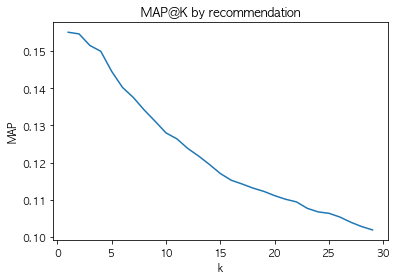

In [57]:
plt.plot(k_list, map_list)
plt.title('MAP@K by recommendation')
plt.xlabel('k')
plt.ylabel('MAP')
plt.show()

## 0.1 ~ 0.2 정로를 채택함!!